In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.datasets import DatasetFolder
from pathlib import Path
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Set the desired image size
image_size = (400, 400)

# Calculate the flattened image size
flattened_size = image_size[0] * image_size[1]

# Define the model
class ImageClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ImageClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
# Define the dimensions for the ImageClassifier
input_dim = 3 * flattened_size  # Adjusted input size to match the flattened image size
hidden_dim = 3
output_dim = 11

In [6]:
# Initialize the network, criterion, and optimizer
model = ImageClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Define transformations for the dataset
transform = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# Create dataset and data loader
dataset = ImageFolder(root='/Users/adityanarayan/Documents/GitHub/sssihl-deep-learning-summer-workshop/week-1/dataset', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Training loop
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Resize the images
        resized_images = torch.nn.functional.interpolate(images, size=image_size)

        # Flatten the images
        flattened_images = resized_images.view(resized_images.size(0), -1)

        # Forward pass
        outputs = model(flattened_images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [12]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient computation for faster inference
with torch.no_grad():
    # Wrap the data_loader with tqdm for a progress bar
    for images, labels in tqdm(data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Resize the images
        resized_images = torch.nn.functional.interpolate(images, size=image_size)
        flattened_images = resized_images.view(resized_images.size(0), -1)
        
        # Forward pass
        outputs = model(flattened_images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

100%|██████████| 215/215 [00:35<00:00,  6.03it/s]


In [13]:
# Print the actual vs predicted labels for each test sample
print("Actual vs Predicted:")
for true_label, predicted_label in zip(true_labels, predicted_labels):
    print(f"Actual: {true_label}, Predicted: {predicted_label}")

Actual vs Predicted:
Actual: 9, Predicted: 9
Actual: 5, Predicted: 8
Actual: 2, Predicted: 9
Actual: 4, Predicted: 4
Actual: 9, Predicted: 9
Actual: 8, Predicted: 8
Actual: 0, Predicted: 8
Actual: 10, Predicted: 8
Actual: 3, Predicted: 9
Actual: 0, Predicted: 9
Actual: 4, Predicted: 4
Actual: 8, Predicted: 8
Actual: 8, Predicted: 8
Actual: 9, Predicted: 9
Actual: 8, Predicted: 8
Actual: 2, Predicted: 1
Actual: 8, Predicted: 1
Actual: 1, Predicted: 9
Actual: 2, Predicted: 9
Actual: 6, Predicted: 8
Actual: 8, Predicted: 8
Actual: 9, Predicted: 9
Actual: 8, Predicted: 8
Actual: 6, Predicted: 4
Actual: 2, Predicted: 8
Actual: 8, Predicted: 8
Actual: 10, Predicted: 8
Actual: 8, Predicted: 8
Actual: 2, Predicted: 9
Actual: 2, Predicted: 0
Actual: 10, Predicted: 1
Actual: 0, Predicted: 4
Actual: 0, Predicted: 0
Actual: 6, Predicted: 0
Actual: 1, Predicted: 9
Actual: 3, Predicted: 9
Actual: 3, Predicted: 8
Actual: 8, Predicted: 9
Actual: 1, Predicted: 8
Actual: 9, Predicted: 1
Actual: 10, Pred

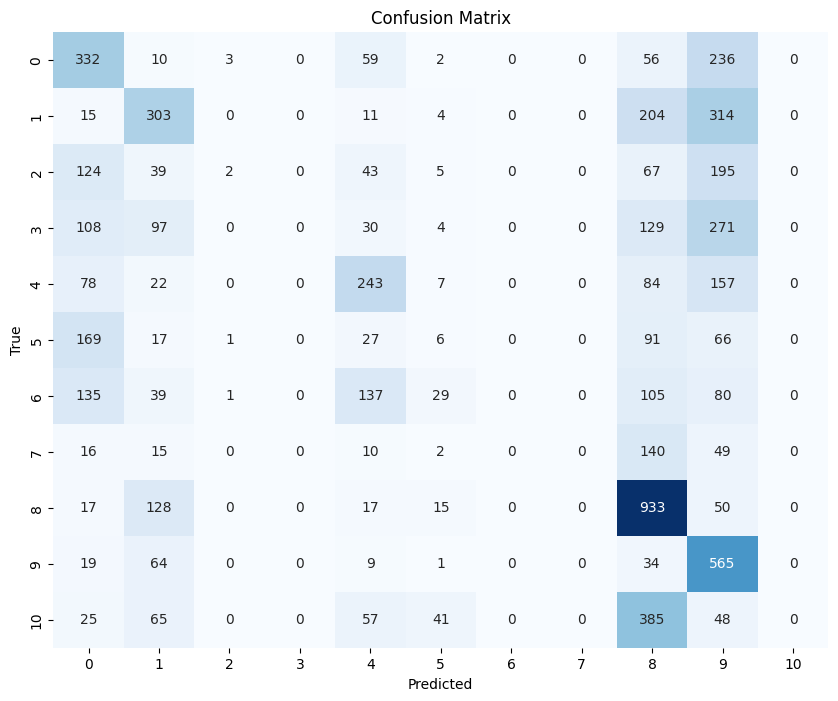

In [15]:
# Plot the confusion matrix using seaborn
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.48      0.38       698
           1       0.38      0.36      0.37       851
           2       0.29      0.00      0.01       475
           3       0.00      0.00      0.00       639
           4       0.38      0.41      0.39       591
           5       0.05      0.02      0.02       377
           6       0.00      0.00      0.00       526
           7       0.00      0.00      0.00       232
           8       0.42      0.80      0.55      1160
           9       0.28      0.82      0.41       692
          10       0.00      0.00      0.00       621

    accuracy                           0.35      6862
   macro avg       0.19      0.26      0.19      6862
weighted avg       0.23      0.35      0.26      6862



/Users/adityanarayan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adityanarayan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adityanarayan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
